<a href="https://colab.research.google.com/github/cruz209/467MGMTGroupWork/blob/main/Unit1_%3CSusan_Chen%3E_DIVE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%bigquery results --project mgmt467-lab
SELECT * FROM `bigquery-public-data.thelook_ecommerce.distribution_centers` #this table name was set based on the table you chose to query

Query is running:   0%|          |

Downloading:   0%|          |

In [3]:
%%bigquery events_df --project mgmt467-lab
SELECT * FROM `bigquery-public-data.thelook_ecommerce.events` LIMIT 1000

Query is running:   0%|          |

Downloading:   0%|          |

In [4]:
%%bigquery inventory_items_df --project mgmt467-lab
SELECT * FROM `bigquery-public-data.thelook_ecommerce.inventory_items` LIMIT 1000

Query is running:   0%|          |

Downloading:   0%|          |

In [5]:
%%bigquery order_items_df --project mgmt467-lab
SELECT * FROM `bigquery-public-data.thelook_ecommerce.order_items` LIMIT 1000

Query is running:   0%|          |

Downloading:   0%|          |

In [6]:
%%bigquery orders_df --project mgmt467-lab
SELECT * FROM `bigquery-public-data.thelook_ecommerce.orders` LIMIT 1000

Query is running:   0%|          |

Downloading:   0%|          |

In [7]:
%%bigquery products_df --project mgmt467-lab
SELECT * FROM `bigquery-public-data.thelook_ecommerce.products` LIMIT 1000

Query is running:   0%|          |

Downloading:   0%|          |

In [8]:
%%bigquery users_df --project mgmt467-lab
SELECT * FROM `bigquery-public-data.thelook_ecommerce.users` LIMIT 1000

Query is running:   0%|          |

Downloading:   0%|          |

In [9]:
# Authenticate and set up the BigQuery client with your project ID
from google.colab import auth
try:
    auth.authenticate_user()
    print('Authenticated')
except Exception as e:
    print(f"Authentication failed: {e}")
    # Exit if authentication fails
    exit()

from google.cloud import bigquery

# Construct a BigQuery client object using your project ID.
client = bigquery.Client(project='mgmt467-lab') # Use your project ID here

print("BigQuery client setup complete.")


Authenticated
BigQuery client setup complete.


# Discover

**Prompt**: You’re the analytics team for “The Look,” an online retailer. Leadership wants a fast, cost-effective analytics pack that (a) surfaces growth opportunities and risks and (b) proposes specific, near-term actions.
Identify the top 3 growth KPIs for the business (e.g., 90-day revenue trend, repeat purchase rate, average order value).

1. Total montly revenue - Tracking this KPI helps us understand seasonal trends, the impact of marketing campaigns, and the overall financial trajectory. A steady increase signals health, while a decline is a primary risk indicator.
2. Repeat purchase rate - measures the percentage of your customers who have made more than one purchase within a specific time frame. most important metrics for gauging customer loyalty and retention.
3. Average Order Value (AOV) - average amount spent each time a customer places an order. Increasing AOV is a powerful way to boost revenue without the added cost of acquiring new customers.


**CTE / Window function example**

**Total Monthly Revenue**

**Prompt:** Use CTEs and window functions to compute trends and MoM/YoY growth for the total monthly revenue KPI

In [10]:
# AI generated SQL for Month-over-Month growth for total monthly revenue
query_combined = """

/*
This query calculates the total monthly revenue and its month-over-month
growth rates. It's designed to give a clear, high-level view of business
performance trends over time.
*/

WITH monthly_revenue AS (
  -- Step 1: CTE to aggregate the total sales revenue for each month.
  -- We extract the year and month from 'created_at' to group orders.
  SELECT
    FORMAT_DATE('%Y-%m', created_at) AS sales_month,
    SUM(sale_price) AS total_revenue
  FROM
    `bigquery-public-data.thelook_ecommerce.order_items`
  WHERE status NOT IN ('Cancelled', 'Returned') -- Exclude non-revenue generating orders
  GROUP BY
    1 -- Group by the first column, sales_month
),

revenue_with_lag AS (
  -- Step 2: Use the LAG() window function to get the previous month's revenue.
  -- This sets up the calculation for the MoM growth rate.
  SELECT
    sales_month,
    total_revenue,
    LAG(total_revenue, 1) OVER (ORDER BY sales_month) AS previous_month_revenue
  FROM
    monthly_revenue
)

-- Step 3: Calculate the final MoM growth percentage.
SELECT
  sales_month,
  total_revenue,
  previous_month_revenue,
  -- Formula: ((Current - Previous) / Previous) * 100
  ROUND(((total_revenue - previous_month_revenue) / previous_month_revenue) * 100, 2) AS mom_growth_percentage
FROM
  revenue_with_lag
ORDER BY
  sales_month DESC; -- Order by most recent month first
"""

results_combined_df = client.query(query_combined).to_dataframe()
display(results_combined_df)

,sales_month,total_revenue,previous_month_revenue,mom_growth_percentage
0,2025-10,601546.920751,397459.980427,51.35
1,2025-09,397459.980427,370171.370210,7.37
2,2025-08,370171.370210,307789.840320,20.27
3,2025-07,307789.840320,282999.330160,8.76
4,2025-06,282999.330160,269665.460281,4.94
...,...,...,...,...
77,2019-05,5213.029991,3926.170017,32.78
78,2019-04,3926.170017,2558.039998,53.48
79,2019-03,2558.039998,2379.509999,7.50
80,2019-02,2379.509999,516.180003,360.98


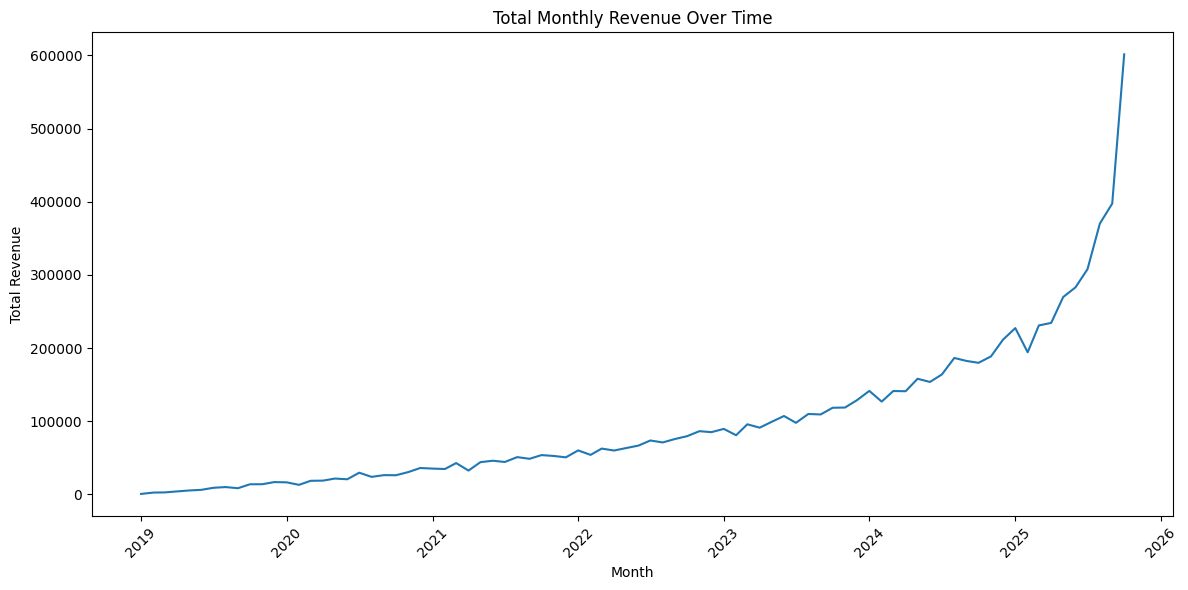

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert 'sales_month' to datetime objects for proper plotting
results_combined_df['sales_month'] = pd.to_datetime(results_combined_df['sales_month'])

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(results_combined_df['sales_month'], results_combined_df['total_revenue'])

# Add titles and labels
plt.title('Total Monthly Revenue Over Time')
plt.xlabel('Month')
plt.ylabel('Total Revenue')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Improve layout to prevent labels overlapping
plt.tight_layout()

# Display the plot
plt.show()

**Repeat Purchase Rate**

**Prompt:** calculate the repeat purchase rate, which measures the percentage of your customers who have made more than one purchase within a year.

In [12]:
# AI generated SQL to calculate Repeat Purchase Rate within a year
query_repeat_purchase_rate_yearly = """

/*
This query calculates the percentage of customers who have made more than
one purchase within a rolling one-year window.
*/

WITH customer_orders AS (
  -- Step 1: Select user ID and order creation date, casting to DATE
  SELECT
    user_id,
    CAST(created_at AS DATE) AS order_date
  FROM
    `bigquery-public-data.thelook_ecommerce.orders`
),

customer_order_history AS (
  -- Step 2: For each order, get the previous order date for the same user, ensuring DATE type
  SELECT
    user_id,
    order_date,
    LAG(order_date, 1) OVER (PARTITION BY user_id ORDER BY order_date) AS previous_order_date
  FROM
    customer_orders
),

repeat_customers_within_year AS (
  -- Step 3: Identify repeat purchases that occurred within one year of the previous purchase
  SELECT
    user_id
  FROM
    customer_order_history
  WHERE
    previous_order_date IS NOT NULL
    AND order_date <= DATE_ADD(previous_order_date, INTERVAL 1 YEAR)
  GROUP BY
    user_id -- Ensure we count each repeat customer only once
),

total_customers AS (
  -- Step 4: Count the total number of unique customers
  SELECT
    COUNT(DISTINCT user_id) AS total_customer_count
  FROM
    `bigquery-public-data.thelook_ecommerce.orders`
),

repeat_customer_count AS (
  -- Step 5: Count the number of unique repeat customers within the year window
  SELECT
    COUNT(DISTINCT user_id) AS repeat_customer_count
  FROM
    repeat_customers_within_year
)

-- Step 6: Calculate the repeat purchase rate percentage
SELECT
  (rc.repeat_customer_count / tc.total_customer_count) * 100 AS repeat_purchase_rate_percentage
FROM
  repeat_customer_count AS rc,
  total_customers AS tc
-- We use a CROSS JOIN here as both CTEs return a single row
;
"""

repeat_purchase_rate_yearly_df = client.query(query_repeat_purchase_rate_yearly).to_dataframe()
display(repeat_purchase_rate_yearly_df)

,repeat_purchase_rate_percentage
0,26.581455


**Average Order Value**

**Prompt:** Calculate the Average Order Value (AOV) - average amount spent each time a customer places an order. Increasing AOV is a powerful way to boost revenue without the added cost of acquiring new customers.

In [13]:
# AI generated SQL to calculate Average Order Value (AOV)
query_aov = """

/*
This query calculates the Average Order Value (AOV).
AOV is calculated as the total revenue divided by the number of unique orders.
*/

SELECT
  SUM(sale_price) / COUNT(DISTINCT order_id) AS average_order_value
FROM
  `bigquery-public-data.thelook_ecommerce.order_items`
WHERE status NOT IN ('Cancelled', 'Returned'); -- Exclude non-revenue generating orders

"""

aov_df = client.query(query_aov).to_dataframe()
display(aov_df)

,average_order_value
0,86.445206


# Investigate

**Prompt**: Deep dive the product category of Accessories, and set the customer segement to people around age 18-30. Along with the potential drivers of traffic source, state, the presence of a discount, and brand to identify key growth levers.

In [14]:
%%bigquery accessory_sales_df --project mgmt467-lab

/*
This query investigates the drivers of "Accessories" sales for customers
aged 18-30. It segments performance by traffic source, state, brand, and
the presence of a discount to identify key growth levers.
*/

-- Step 1: CTE to join tables and filter for the specific
-- product category (Accessories) and customer segment (Ages 18-30).
WITH accessory_sales_young_adults AS (
  SELECT
    u.traffic_source,
    u.state,
    p.brand, -- Added brand to the select list
    -- Create a simple boolean flag to check if a discount was applied.
    (p.retail_price - oi.sale_price) > 0.01 AS has_discount,
    oi.sale_price,
    p.retail_price,
    oi.order_id
  FROM
    `bigquery-public-data.thelook_ecommerce.order_items` AS oi
  JOIN
    `bigquery-public-data.thelook_ecommerce.users` AS u
    ON oi.user_id = u.id
  JOIN
    `bigquery-public-data.thelook_ecommerce.products` AS p
    ON oi.product_id = p.id
  WHERE
    p.category = 'Accessories' -- Focusing on the "Accessories" category
    AND u.age BETWEEN 18 AND 30 -- Defining our "Young Adult" segment
    AND oi.status NOT IN ('Cancelled', 'Returned') -- Ensure we only count completed sales
)

-- Step 2: Aggregate the data to find performance drivers.
-- We group by our potential drivers to see how metrics change across them.
SELECT
  traffic_source,
  state,
  brand, -- Added brand to the group by and select list
  has_discount,
  COUNT(DISTINCT order_id) AS number_of_orders,
  SUM(sale_price) AS total_revenue,
  -- Calculate the average discount % for this segment
  AVG((retail_price - sale_price) / retail_price) * 100 AS average_discount_percent
FROM
  accessory_sales_young_adults
GROUP BY
  traffic_source,
  state,
  brand, -- Added brand to the group by
  has_discount
ORDER BY
  total_revenue DESC -- Sort to see the top-performing segments first
LIMIT 25; -- Limit for a digestible summary

Query is running:   0%|          |

Downloading:   0%|          |

In [15]:
display(accessory_sales_df)

,traffic_source,state,brand,has_discount,number_of_orders,total_revenue,average_discount_percent
0,Search,Guangdong,Oakley,False,4,750.000000,0.0
1,Search,Jiangsu,Ray-Ban,False,3,412.889999,0.0
2,Search,Guangdong,Ray-Ban,False,4,404.450005,0.0
3,Search,Oklahoma,Oakley,False,2,399.000000,0.0
4,Search,England,Oakley,False,2,390.000000,0.0
5,Search,Hebei,Ray-Ban,False,3,326.169998,0.0
6,Search,Zhejiang,Oakley,False,2,310.000000,0.0
7,Search,Scotland,Maui Jim,False,1,299.000000,0.0
8,Search,Zhejiang,Tom Ford,False,1,296.450012,0.0
9,Search,Gyeonggi-do,Ray-Ban,False,3,295.100006,0.0


In [16]:
# Classify options for each driver

print("--- Traffic Source Options ---")
display(accessory_sales_df['traffic_source'].value_counts())

print("\n--- State Options (Top 20) ---")
display(accessory_sales_df['state'].value_counts().head(20))

print("\n--- Brand Options (Top 20) ---")
display(accessory_sales_df['brand'].value_counts().head(20))

print("\n--- Has Discount Options ---")
display(accessory_sales_df['has_discount'].value_counts())

--- Traffic Source Options ---


,count
traffic_source,
Search,23
Organic,2



--- State Options (Top 20) ---


,count
state,
Guangdong,2
England,2
Zhejiang,2
Comunidad Valenciana,2
Jiangsu,1
Hebei,1
Oklahoma,1
Gyeonggi-do,1
Scotland,1



--- Brand Options (Top 20) ---


,count
brand,
Ray-Ban,10
Oakley,8
Costa Del Mar,2
Dolce & Gabbana,2
Maui Jim,1
Tom Ford,1
Carrera,1



--- Has Discount Options ---


,count
has_discount,
False,25


# Validate

## Identify two ai-generated sql queries for cross-checking


Prompt: Cross-check the total monthly revenue, but only focuses on 2025 to see if it matched with the visualization of the KPI: Total Monthly revenue

In [17]:
# Cross-checking the Total Monthly Revenue by focusing on 2025
query_2025_revenue = """

/*
This query calculates the total monthly revenue specifically for the year 2025.
This helps in cross-checking the overall monthly revenue trend and verifying
the significant increase observed in 2025 data.
*/

SELECT
  FORMAT_DATE('%Y-%m', created_at) AS sales_month,
  SUM(sale_price) AS total_revenue_2025
FROM
  `bigquery-public-data.thelook_ecommerce.order_items`
WHERE
  -- Filter for orders created in the year 2025
  EXTRACT(YEAR FROM created_at) = 2025
  AND status NOT IN ('Cancelled', 'Returned') -- Exclude non-revenue generating orders
GROUP BY
  1 -- Group by sales_month
ORDER BY
  sales_month; -- Order chronologically
"""

revenue_2025_df = client.query(query_2025_revenue).to_dataframe()
display(revenue_2025_df)

,sales_month,total_revenue_2025
0,2025-01,227247.000201
1,2025-02,194121.760188
2,2025-03,230841.050194
3,2025-04,234322.970436
4,2025-05,269665.460281
5,2025-06,282999.330160
6,2025-07,307789.840320
7,2025-08,370171.370210
8,2025-09,397459.980427
9,2025-10,601546.920751


**Cross Check**:
Implement and execute the alternative SQL query for cross-checking the second AI-generated query (Repeat Purchase Rate).

Be more specified by checking the repeat purchase rate each month, and see if there is any growth or trend.



In [18]:
# --- Cross-checking Query 2: Repeat Purchase Rate ---
query_repeat_purchase_rate_alternative_2 = """

/*
Alternative query to calculate repeat purchase rate by cohort month.
It identifies users who placed their first order in a given month and
checks if they placed any subsequent order at any point after their first order.
This provides a cohort-based view of repeat purchases, not strictly within a year window,
to contrast with the original query's rolling one-year window and overall rate.
*/

WITH first_order_dates AS (
  -- Find the first order date for each user
  SELECT
    user_id,
    MIN(created_at) AS first_order_date
  FROM
    `bigquery-public-data.thelook_ecommerce.orders`
  GROUP BY
    user_id
),

repeat_customers AS (
  -- Identify users who have placed more than one order
  SELECT
    user_id
  FROM
    `bigquery-public-data.thelook_ecommerce.orders`
  WHERE status NOT IN ('Cancelled', 'Returned') -- Exclude non-revenue generating orders
  GROUP BY
    user_id
  HAVING
    COUNT(DISTINCT order_id) > 1
),

monthly_cohorts AS (
  -- Determine the cohort month (based on first order date) and count total users in each cohort
  SELECT
    FORMAT_DATE('%Y-%m', first_order_date) AS cohort_month,
    COUNT(DISTINCT user_id) AS total_cohort_users
  FROM
    first_order_dates
  GROUP BY
    1
),

retained_cohort_users AS (
  -- Count repeat users within each cohort
  SELECT
    FORMAT_DATE('%Y-%m', fod.first_order_date) AS cohort_month,
    COUNT(DISTINCT rc.user_id) AS repeat_cohort_user_count
  FROM
    repeat_customers AS rc
  JOIN
    first_order_dates AS fod
    ON rc.user_id = fod.user_id
  GROUP BY
    1
)

-- Calculate the repeat purchase rate for each cohort
SELECT
  mc.cohort_month,
  mc.total_cohort_users,
  COALESCE(rcu.repeat_cohort_user_count, 0) AS repeat_cohort_user_count,
  ROUND(COALESCE(rcu.repeat_cohort_user_count, 0) * 100.0 / mc.total_cohort_users, 2) AS cohort_repeat_purchase_rate_percentage
FROM
  monthly_cohorts AS mc
LEFT JOIN
  retained_cohort_users AS rcu
  ON mc.cohort_month = rcu.cohort_month
ORDER BY
  mc.cohort_month;

"""


In [19]:
# Execute the alternative query for repeat purchase rate
repeat_purchase_rate_alternative_2_df = client.query(query_repeat_purchase_rate_alternative_2).to_dataframe()
display(repeat_purchase_rate_alternative_2_df)

,cohort_month,total_cohort_users,repeat_cohort_user_count,cohort_repeat_purchase_rate_percentage
0,2019-01,13,3,23.08
1,2019-02,28,12,42.86
2,2019-03,36,16,44.44
3,2019-04,55,25,45.45
4,2019-05,90,37,41.11
...,...,...,...,...
77,2025-06,2368,398,16.81
78,2025-07,2613,411,15.73
79,2025-08,2839,433,15.25
80,2025-09,3073,402,13.08


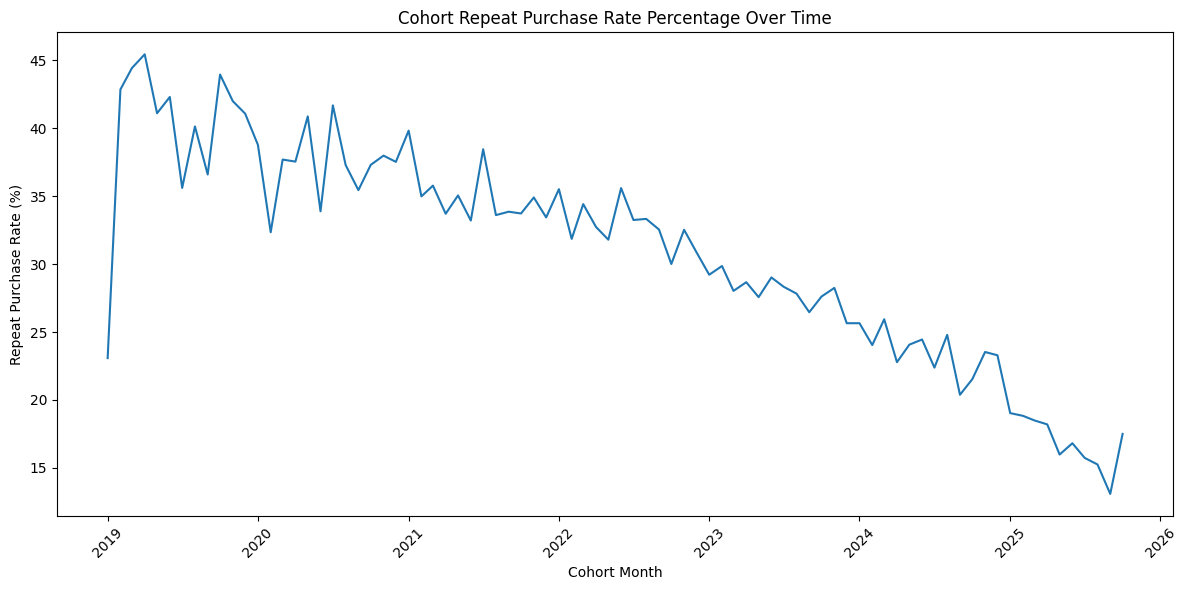

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert 'cohort_month' to datetime objects for proper plotting
repeat_purchase_rate_alternative_2_df['cohort_month'] = pd.to_datetime(repeat_purchase_rate_alternative_2_df['cohort_month'])

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(repeat_purchase_rate_alternative_2_df['cohort_month'], repeat_purchase_rate_alternative_2_df['cohort_repeat_purchase_rate_percentage'])

# Add titles and labels
plt.title('Cohort Repeat Purchase Rate Percentage Over Time')
plt.xlabel('Cohort Month')
plt.ylabel('Repeat Purchase Rate (%)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Improve layout to prevent labels overlapping
plt.tight_layout()

# Display the plot
plt.show()

**Misleading Answer:**

In [21]:
query_repeat_purchase_value = """
WITH user_orders AS (
  SELECT
    user_id,
    COUNT(DISTINCT order_id) AS order_count,
  FROM
    `bigquery-public-data.thelook_ecommerce.order_items`
  GROUP BY
    user_id
  HAVING
    order_count > 1
),

repeat_customer_order AS (
  Select
    oi.sale_price
  FROM
    `bigquery-public-data.thelook_ecommerce.order_items` AS oi
  JOIN
    user_orders AS uoc
    ON oi.user_id = uoc.user_id
  WHERE
    oi.status NOT IN ('Cancelled', 'Returned')
)

SELECT
  SUM(sale_price) AS total_revenue
FROM
  repeat_customer_order
"""

repeat_purchase_value_df = client.query(query_repeat_purchase_value).to_dataframe()
display(repeat_purchase_value_df)

,total_revenue
0,4.839582e+06


# DIVE Reflection

While generating for the repeat purchase value, the prompt was not clear enough by prompting: calculate the repeat purchase value of the ecommerce dataset. It did gave the sum of sales price of orders from customers by making more than 1 purchase. But it is unclear about how much or how many of these repetitive customers make up our customer segments. Since it also did not specify the time range, a really big number can only confuse the team.

So the new prompt is: **calculate the repeat purchase rate, which measures the percentage of your customers who have made more than one purchase within a year. (the repeat purchase rate SQL in Discover section)** Which not only provide the percentage of the customers, but specfied to a year to see if they are a big part of our customer segments, and if it is possible to have loyal programs towards customers.

To ensure a even better clarity, the Cohort-Based Repeat Purchase Rate is generated as an alternative query to know the loyal customers better. Instead of a year, it updated to every month and see the number and percentage of customers that made an additional purchased after the first purchase. It helps with our online store to develop a loyal program and bring in more long-term customers to increase our profit.


# Extend
**Prompt for All 3 Graphs:** Create interactive Plotly charts for Scorecard: revenue (or profit), last 30 days, Pie/Donut: sales % by region or channel, Bar: top 5 products/categories.

## Scorecard: revenue (or profit), last 30 days

**Prompt:** Write and execute a SQL query to get the total revenue (or profit) for the last 30 days based on the latest data in the dataset.

In [22]:

query_last_30_days_revenue = """
SELECT
  SUM(sale_price) AS total_revenue_last_30_days
FROM
  `bigquery-public-data.thelook_ecommerce.order_items`
WHERE
  created_at >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 30 DAY)
  AND status NOT IN ('returned_at', 'Cancelled') -- Exclude 'returned_at' and 'Cancelled' statuses
"""

last_30_days_revenue_df = client.query(query_last_30_days_revenue).to_dataframe()
display(last_30_days_revenue_df)

,total_revenue_last_30_days
0,791447.650964


In [23]:
import plotly.graph_objects as go

# Get the total revenue from the DataFrame
last_30_days_revenue = last_30_days_revenue_df['total_revenue_last_30_days'].iloc[0]

# Create a Plotly Indicator chart
fig = go.Figure(go.Indicator(
    mode = "number",
    value = last_30_days_revenue,
    number = {'prefix': "$"},
    title = {"text": "Total Revenue (Last 30 Days)"},
))

fig.update_layout(
    margin=dict(l=0, r=0, t=50, b=0) # Adjust margins for better fit
)

fig.show()

**Recommendation:** Instead of only displaying the revenue for last 30 days, adding the score chart of the months before helps the companie to compare and see if there is an increase in sales. It also shows the trend or seasonlity in a year.

# Pie Chart: sales % by channel

**Prompt:**  Query data for Sales % by Channel (Traffic Source)


In [24]:
query_sales_by_channel = """
SELECT
  u.traffic_source,
  SUM(oi.sale_price) AS total_sales
FROM
  `bigquery-public-data.thelook_ecommerce.order_items` AS oi
JOIN
  `bigquery-public-data.thelook_ecommerce.orders` AS o
  ON oi.order_id = o.order_id
JOIN
  `bigquery-public-data.thelook_ecommerce.users` AS u
  ON o.user_id = u.id
WHERE oi.status NOT IN ('Cancelled', 'Returned')
GROUP BY
  u.traffic_source
ORDER BY
  total_sales DESC;
"""

sales_by_channel_df = client.query(query_sales_by_channel).to_dataframe()
display(sales_by_channel_df)

,traffic_source,total_sales
0,Search,5.648516e+06
1,Organic,1.204692e+06
2,Facebook,4.969381e+05
3,Email,4.104699e+05
4,Display,3.186394e+05


In [25]:
import plotly.express as px

# Create a Plotly Pie Chart
fig = px.pie(sales_by_channel_df,
             values='total_sales',
             names='traffic_source',
             title='Sales Percentage by Channel')

fig.update_layout(
    margin=dict(l=0, r=0, t=50, b=0) # Adjust margins for better fit
)

fig.show()

**Recommendation:** Focusing on the top channel to capitalize on the exiting successful sources. Also try to investigate in the low performing channel to understand why the advertisement is not working on those channels.

# Bar: top 5 products/categories

**Prompt:**  Query data for Top 5 Product Categories by Sales


In [26]:
query_top_categories = """
SELECT
  p.category,
  SUM(oi.sale_price) AS total_sales
FROM
  `bigquery-public-data.thelook_ecommerce.order_items` AS oi
JOIN
  `bigquery-public-data.thelook_ecommerce.products` AS p
  ON oi.product_id = p.id
WHERE oi.status NOT IN ('Cancelled', 'Returned')
GROUP BY
  p.category
ORDER BY
  total_sales DESC
LIMIT 5;
"""

top_categories_df = client.query(query_top_categories).to_dataframe()
display(top_categories_df)

,category,total_sales
0,Outerwear & Coats,990388.319231
1,Jeans,936819.711269
2,Sweaters,634188.780219
3,Swim,488203.790647
4,Fashion Hoodies & Sweatshirts,482541.690217


In [27]:
import plotly.express as px

# Create a Plotly Bar Chart for Top 5 Categories
fig = px.bar(top_categories_df,
             x='category',
             y='total_sales',
             title='Top 5 Product Categories by Sales',
             labels={'category': 'Product Category', 'total_sales': 'Total Sales Revenue'})

fig.update_layout(
    xaxis={'categoryorder':'total descending'}, # Order bars by total sales
    margin=dict(l=0, r=0, t=50, b=0) # Adjust margins for better fit
)

fig.show()

**Recommendation:** Since these are the top selling product categories, it is important to keep them in stock and reduce the possibility of shortage. It also helps the management to consider having more products from these categories to keep boosting the sales.